# DBScan Smiley

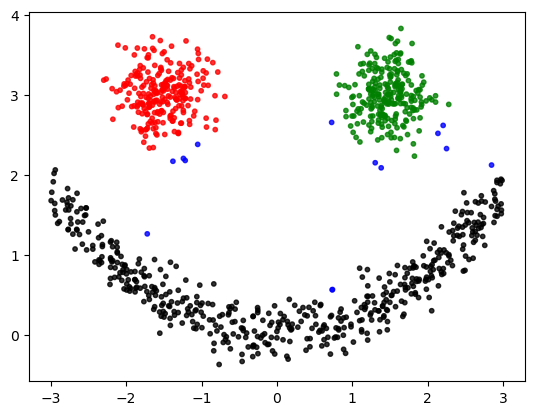

In [48]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

TEMPFILE = 'temp.png'

class DBC():

    def __init__(self, dataset, min_pts, epsilon):
        self.dataset = dataset
        self.min_pts = min_pts 
        self.epsilon = epsilon
        self.snaps = []
        self.assignments = [0 for _ in range(len(self.dataset))]


    def snapshot(self, i):
        fig, ax = plt.subplots()
        colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk']) # define colors for plotting clusters

        # plot all the datapoints with different colors based on their assignment
        ax.scatter(self.dataset[:, 0], self.dataset[:, 1], color=colors[self.assignments].tolist(), s=10, alpha=0.8)
        
        cir = plt.Circle(self.dataset[i], self.epsilon, color=colors[self.assignments[i]], fill=False)
        ax.add_patch(cir)
        
        # set the x and y limits of the plot
        ax.set_xlim(-5, 5)
        ax.set_ylim(-2, 6)
        ax.set_aspect('equal')
        fig.savefig(TEMPFILE)
        plt.close()
        return im.fromarray(np.asarray(im.open(TEMPFILE)))

    def is_core(self, i):
        neighbours = []
        for j in range(len(self.dataset)):
            if i != j and np.linalg.norm(self.dataset[i] - self.dataset[j]) <= self.epsilon:
                neighbours.append(j)
                
        return len(neighbours) >= self.min_pts
    
    def get_unlabeled_neighbours(self, i):
        neighbours = []
        
        for j in range(len(self.dataset)):
            if i != j and self.assignments[j] == 0 and np.linalg.norm(self.dataset[i] - self.dataset[j]) <= self.epsilon:
                neighbours.append(j)
                
        return neighbours
    
    def dfs_assign(self, i, cluster_number):
        self.assignments[i] = cluster_number
        self.snaps.append(self.snapshot(i))
        neighbours = self.get_unlabeled_neighbours(i)
        while neighbours:
            next_candidate = neighbours.pop()
            if self.assignments[next_candidate] != 0:
                continue
                
            self.assignments[next_candidate] = cluster_number
            self.snaps.append(self.snapshot(next_candidate))
            if self.is_core(next_candidate):
                # Explore the neighbourhood of the core point
                neighbours += self.get_unlabeled_neighbours(next_candidate) # creates a flattened list, instead of a list of list

    def dbscan(self):
        """
        returns a list of assignments. The index of the
        assignment should match the index of the data point
        in the dataset.
        """
        cluster_number = 1
        for i in range(len(self.dataset)): # Need the corresponding assignment, so use index
            if self.assignments[i] != 0:
                # already assigned to a cluster - no need to re-evaluate
                continue
                
            if self.is_core(i):
                self.dfs_assign(i, cluster_number)
            cluster_number += 1
        return self.assignments


centers = [[-1.5,3],[1.5,3]]
eyes, _ = datasets.make_blobs(n_samples = 500, centers = centers, cluster_std = 0.3, random_state = 0)

mouth_x = -3 + 6 * np.random.random(size = (500,))
mouth_y = 0.2 * mouth_x**2 + 0.2 * np.random.randn(500)

face = np.append(eyes, list(zip(mouth_x, mouth_y)), axis=0)

dbc = DBC(face, 3, .2)
clustering = dbc.dbscan()
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk']) # blue, green red, cyan, magenta, yellow, black
colors = np.hstack([colors] * 30)
plt.scatter(face[:, 0], face[:, 1], color=colors[clustering].tolist(), s=10, alpha=0.8)
plt.show()

dbc.snaps[0].save(
    'dbscan.gif',
    optimize=False,
    save_all=True,
    append_images=dbc.snaps[1:],
    loop=0,
    duration=25
)
